In [4]:
import os
import tqdm
import numpy as np
from rlr_audio_propagation import Context, Config, ChannelLayout, ChannelLayoutType
import trimesh
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point, MultiPolygon

glb_file = "data/scene_datasets/gibson_data/gibson_medium/Adairsville/mesh.obj"
ply_file = os.path.dirname(glb_file) + '_semantic.ply'
name = os.path.basename(glb_file).rsplit('.', 1)[0]
out_dir = "output"
os.makedirs(out_dir, exist_ok=True)
ch = 4 
n = 18 

In [5]:
def plot_wav(fname, out_fname):
    y, sr = librosa.load(fname, mono=False)
    plt.figure(figsize=(10, 6))
    for i, yi in enumerate(y):
        ix=np.where(yi!=0)[0]
        if len(ix)>1:
            yi = yi[ix[0]:ix[-1]]
        librosa.display.waveshow(yi, sr=sr, alpha=0.5, label=f'Channel {i} ({np.abs(yi).max():.2g})')
    plt.legend()
    plt.savefig(out_fname)
    return y

def add_sphere(scene, pos, color=[0,0,0], r=0.4, **kw):
    sphere = trimesh.creation.uv_sphere(radius=r)
    sphere.apply_translation(pos)
    sphere.visual.face_colors = color
    name = scene.add_geometry(sphere)
    return sphere, name

def draw_3d(scene, out_fname, mic_pos, source_pos):
    mic_sphere, mic_name = add_sphere(scene, mic_pos,[255, 0, 0])
    source_sphere, source_name = add_sphere(scene, source_pos,[0, 255, 0])
    with open(out_fname, 'wb') as f:
        f.write(scene.save_image((100, 100)))
    scene.delete_geometry([mic_name, source_name])


def draw_grid(scene, xs, ys, zs, out_fname):
    scene = scene.copy()
    for x in xs:
        for y in ys:
            for z in zs:
                _, name = add_sphere(scene, [x, y, z], [0, 0, 255])
    return scene


def get_scene_bounding_box(scene):
    min_bound = np.array([np.inf, np.inf, np.inf])
    max_bound = np.array([-np.inf, -np.inf, -np.inf])
    
    for geometry in scene.geometry.values():
        if isinstance(geometry, trimesh.Trimesh):
            min_bound = np.minimum(min_bound, geometry.bounds[0])
            max_bound = np.maximum(max_bound, geometry.bounds[1])
    return min_bound, max_bound


def generate_grid_points(min_bound, max_bound, boundaries, spacing=0.5):
    x_points = np.arange(min_bound[0], max_bound[0], spacing)
    y_points = np.arange(min_bound[1], max_bound[1], spacing)
    z_points = np.arange(min_bound[2], max_bound[2], spacing)
    grid_points = np.array(np.meshgrid(x_points, y_points, z_points)).T.reshape(-1, 3)
    
    # Convert boundaries to a list of shapely Polygon objects
    polygons = [Polygon(boundary) for boundary in boundaries]
    
    # Create a MultiPolygon object from the list of polygons
    multi_polygon = MultiPolygon(polygons)
    
    # Filter grid points that fall within the MultiPolygon
    points_within_boundaries = []
    for point in grid_points:
        if multi_polygon.contains(Point(point[0], point[1])):
            points_within_boundaries.append(point)
    
    return np.array(points_within_boundaries)


def get_2d_mesh_boundaries(scene):
    boundaries = []
    for geometry in scene.geometry.values():
        if isinstance(geometry, trimesh.Trimesh):
            # Get the 2D projection of the mesh (ignoring z-axis)
            vertices_2d = geometry.vertices[:, :2]
            # Compute 2D convex hull (smallest convex polygon that contains all the points) 
            hull = ConvexHull(vertices_2d)
            # Get the vertices of the convex hull in order
            boundary = vertices_2d[hull.vertices]
            boundaries.append(boundary)
    return boundaries

def generate_3d_grid_points(min_bound, max_bound, spacing=0.5):
    x_points = np.arange(min_bound[0], max_bound[0], spacing)
    y_points = np.arange(min_bound[1], max_bound[1], spacing)
    z_points = np.arange(min_bound[2], max_bound[2], spacing)
    grid_points = np.array(np.meshgrid(x_points, y_points, z_points)).T.reshape(-1, 3)
    return grid_points

def filter_points_outside_mesh(scene, grid_points):
    filtered_points = []
    for point in grid_points:
        # Check if the point is inside any of the meshes in the scene
        is_outside = True
        for geometry in scene.geometry.values():
            if isinstance(geometry, trimesh.Trimesh) and geometry.contains([point]):
                is_outside = False
                break
        if not is_outside:
            filtered_points.append(point)
    return np.array(filtered_points)

In [6]:
mic_pos = np.array([-4, 1, -2])
source_pos = np.array([0, 1.5, -2])
mic_pos = np.array([0, 0, 1])
source_pos = np.array([0, 2, 1.5])

cfg = Config()
ctx = Context(cfg)
ctx.add_object()
ctx.set_object_position(0, [0, 0, 0])
ctx.add_source()
ctx.add_listener(ChannelLayout(ChannelLayoutType.Ambisonics, 4))

In [7]:
glb_file = "data/scene_datasets/gibson_data/gibson_medium/Adairsville/mesh.obj"
scene = trimesh.load(glb_file)
if not isinstance(scene, trimesh.Scene):
    scene = trimesh.Scene(scene)

# Calculate the bounding box of the scene
min_bound, max_bound = get_scene_bounding_box(scene)
print(f"Scene bounding box: min {min_bound}, max {max_bound}")

# Get 2D mesh boundaries
mesh_boundaries = get_2d_mesh_boundaries(scene)

# Generate a grid of points within the 2D mesh boundaries
grid_points = generate_grid_points(min_bound, max_bound, mesh_boundaries, spacing=0.1)
print(f"Generated {len(grid_points)} grid points within the 2D mesh boundaries")

plt.figure(figsize=(10, 10))
plt.scatter(grid_points[:, 0], grid_points[:, 1], c='r', s=1, alpha=0.5)
for boundary in mesh_boundaries:
    plt.plot(boundary[:, 0], boundary[:, 1], 'b-', linewidth=2)
    plt.plot([boundary[-1, 0], boundary[0, 0]], [boundary[-1, 1], boundary[0, 1]], 'b-', linewidth=2)
plt.title('2D View of Grid Points and Mesh Boundaries')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
out_dir = "output"
name = "Adairsville"
plt.savefig(f'{out_dir}/grid_points_and_mesh_{name}.png', dpi=300, bbox_inches='tight')
plt.close()

print(f"2D plot with mesh boundaries saved as {out_dir}/grid_points_and_mesh_{name}.png")

Scene bounding box: min [-9.06576 -2.85238 -4.67383], max [0.916793 9.11703  1.04151 ]
Generated 611726 grid points within the 2D mesh boundaries
2D plot with mesh boundaries saved as output/grid_points_and_mesh_Adairsville.png


Scene bounding box: min [-9.06576 -2.85238 -4.67383], max [0.916793 9.11703  1.04151 ]
Generated 5760 grid points in 3D space
Filtered 2490 grid points outside scene geometry


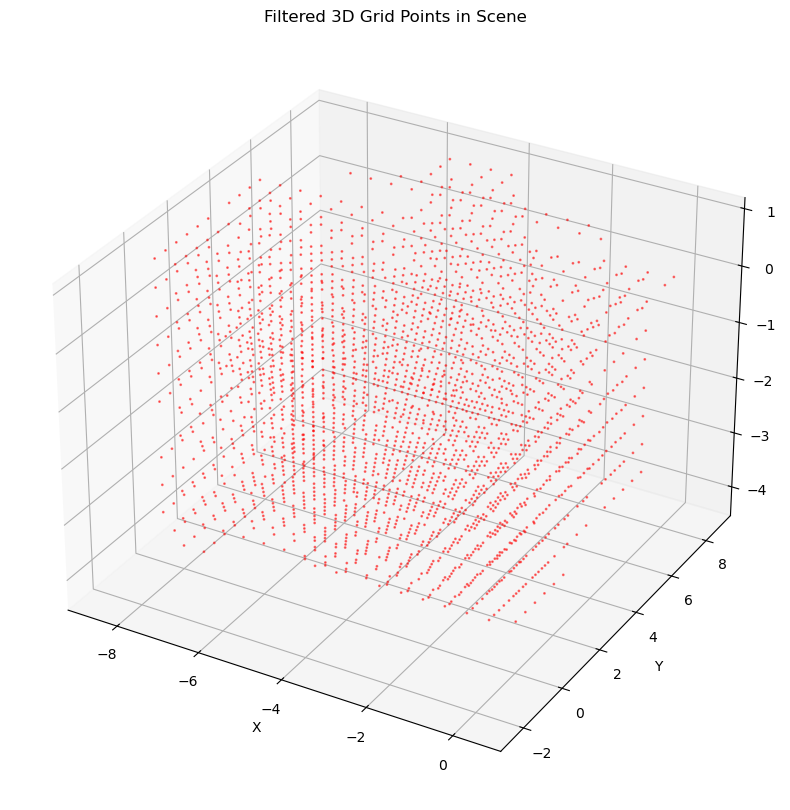

In [7]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt

glb_file = "data/scene_datasets/gibson_data/gibson_medium/Adairsville/mesh.obj"
scene = trimesh.load(glb_file)
if not isinstance(scene, trimesh.Scene):
    scene = trimesh.Scene(scene)

# Calculate bounding box of scene
min_bound, max_bound = scene.bounds
print(f"Scene bounding box: min {min_bound}, max {max_bound}")

# Generate 3D grid points within the scene bounds
grid_spacing = 0.5  
grid_points = generate_3d_grid_points(min_bound, max_bound, spacing=grid_spacing)
print(f"Generated {len(grid_points)} grid points in 3D space")

# filter grid points that intersect with scene geometry
filtered_points = filter_points_outside_mesh(scene, grid_points)
print(f"Filtered {len(filtered_points)} grid points outside scene geometry")

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(filtered_points[:, 0], filtered_points[:, 1], filtered_points[:, 2], c='r', s=1, alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Filtered 3D Grid Points in Scene')
plt.show()